# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

**A quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)**

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [1]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [2]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [3]:
# TODO: Enter code here to vectorize the data and store it in a variable `reviews`

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')
reviews = vectorizer.fit_transform(df.text)

Test your vectorization by running the following code cell:

In [4]:
reviews.shape

(11914, 46619)

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. Start with $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value.

In [5]:
# TODO: Enter code here to cluster the vectorized data
from sklearn.cluster import KMeans
KM_cluster = KMeans(n_clusters = 3, 
                    n_init = 5, 
                    random_state = 999,
                    algorithm = 'elkan').fit(reviews)

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

<AxesSubplot:>

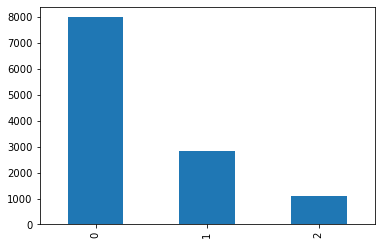

In [6]:
# TODO: Enter code here to produce a bar plot of the cluster size

pd.value_counts(KM_cluster.labels_).plot(kind = 'bar')


Note that sizes may vary considerable between clusters and among different random seeds.

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

**Hint:** You will need to construct an &lsquo;inverted vocabulary&rsquo; that allows you to map from the index of a term back to the original term.

In [7]:
# TODO: Enter code here to compute the cluster summaries and print them
import numpy as np

n = 15

centroids = KM_cluster.cluster_centers_
vocabulary = {value:key for key,value in vectorizer.vocabulary_.items()}

for i in range(len(centroids)):
    index = np.argsort(centroids[i])[-n:]
    print(f"{i} : {[vocabulary[j] for j in index]}")


0 : ['really', 'software', 'work', 'did', 'music', 'does', 'time', 'good', 'use', 'album', 'just', 'great', 'cd', 'like', 'product']
1 : ['characters', 'people', 'really', 'quot', 'did', 'great', 'books', 'good', 'just', 'like', 'story', 'read', 'film', 'movie', 'book']
2 : ['zoom', 'picture', 'cameras', 'good', 'case', 'great', 'quality', 'battery', 'flash', 'use', 'digital', 'canon', 'pictures', 'lens', 'camera']


Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

*We saw earlier that cluster0 was the most "dense" and it is also reflected in the summary that the clustering is not very good for this cluster. There are some words that indicate a cluster about music with words like - album, cd, music. But then there are some common english words like - like, really, did. The second cluster is also a bit confusing because there are 2 themes - books & movies. It can be reasoned that common words can be used in reviews about movies & books like - story, characters, people, which is what the summary reflects. The third cluster is the smallest & most clearest. It seems to be about reviews for different camera models.*

## Problem 3: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on (unordered) pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label. You are supposed to implement the procedure yourselves, not import an external function.

Compare clusterings with $k \in \{1,3,5,7\}$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column).

In [8]:
# TODO: Enter code here to (manually) compute the Rand indices for the two clusterings

from scipy.special import comb

k = [1,3,5,7]
eval_data = df[:500]
eval_labels = pd.factorize(eval_data.category)[0]
eval_reviews = reviews[:500]

def rand_index(cluster_labels, goldstandard_labels):
    
    # TP+FP = sum(nC2 for each cluster)
    tp_fp = sum(comb(pd.value_counts(cluster_labels), 2))
    
    # TP+FN = sum(nC2 for goldstandard labels)
    tp_fn = sum(comb(pd.value_counts(goldstandard_labels), 2))
    
    # create ordered pairs of cluster labels & goldstandard labels
    ord_pairs = np.r_['1,2,0', cluster_labels, goldstandard_labels]
    
    # TP = sum(For each cluster sum(number_matching_labels CHOOSE 2))
    tp = sum(sum(comb(pd.value_counts(ord_pairs[ord_pairs[:, 0] == i, 1]), 2)) for i in np.unique(cluster_labels))
    
    # FP = TP+FP - TP
    fp = tp_fp - tp
    
    # FN = TP+FN - TP
    fn = tp_fn - tp
    
    # TN = nC2 - TP - FP - FN
    tn = comb(len(ord_pairs), 2) - tp - fp - fn
    
    # return rand_index
    return (tp + tn)/(tp + fp + fn + tn)


for i in k:
    KM = KMeans(n_clusters = i,
                n_init = 5, 
                random_state = 999).fit(reviews)
    
    cluster_labels = KM.labels_[:500]
    
    print(f"Rand Index for Clustering with k = {i} : {round(rand_index(cluster_labels, eval_labels),4)}")
    
    
    
    


Rand Index for Clustering with k = 1 : 0.1663
Rand Index for Clustering with k = 3 : 0.5572
Rand Index for Clustering with k = 5 : 0.6834
Rand Index for Clustering with k = 7 : 0.764


*As we kept increasing the allowed clusters, the higher RI values we see. Which implies that the dataset has multiple categories. In the previous step we saw that with k=3, we were getting a very large meaningless cluster0, but the second cluster seemed to be a mix of 2 topics. The third cluster had a clear theme. This exercise shows that going as high as k=7 only gives about 76% accuracy for the data clustering.*

## Topic modelling data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [9]:
with open('sotu_1975_2000.txt') as source:
    for i, line in enumerate(source):
        print(line.rstrip())
        if i >= 5:
            break

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

*Possible topics: political speech, unemployment, ceremony, agenda*

## Problem 4: Train a topic model

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy. Given that the data set for this problem is rather small, you do not have to exclude any components from the standard pipeline. Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [10]:
# TODO: Replace the following lines with your own code for preprocessing the documents
import spacy

nlp = spacy.load("en_core_web_sm", disable=['senter'])
def preprocess(text):
    doc_list = []
    for token in nlp(text):
        if token.is_stop is False and token.is_alpha is True and len(token) >= 3:
            doc_list.append(token.text)
    return doc_list

with open('sotu_1975_2000.txt') as source:
    documents = [preprocess(line) for line in source]

D:\Anaconda\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['senter'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


Test your preprocessing by running the following cell:

In [11]:
' '.join(documents[42])

'reduce oil imports million barrels day end year million barrels day end'

You should get the following output:

Once you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. (Note that you cannot use the standard scikit-learn pipeline in this case.) Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [12]:
# TODO: Enter code here to train an LDA model and store it in a variable `model`
# most of the code in this section is taken from the gensim documentation

from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(documents)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8496
Number of documents: 2898


In [13]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
#chunksize = 2000
#passes = 20
#iterations = 400
#eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    #chunksize=chunksize,
    #alpha='auto',
    #eta='auto',
    #iterations=iterations,
    num_topics=num_topics,
    #passes=passes,
    #eval_every=eval_every
)

Once you have a trained model, run the following cell to print the topics:

In [14]:
model.print_topics()

[(0,
  '0.018*"world" + 0.015*"america" + 0.009*"people" + 0.007*"american" + 0.006*"economy" + 0.006*"years" + 0.006*"peace" + 0.006*"nation" + 0.006*"work" + 0.006*"tonight"'),
 (1,
  '0.017*"america" + 0.014*"people" + 0.011*"new" + 0.008*"know" + 0.007*"work" + 0.007*"trade" + 0.007*"american" + 0.006*"thank" + 0.006*"help" + 0.006*"way"'),
 (2,
  '0.008*"covenant" + 0.007*"grade" + 0.007*"new" + 0.006*"energy" + 0.006*"people" + 0.006*"year" + 0.005*"world" + 0.005*"know" + 0.005*"surplus" + 0.005*"challenge"'),
 (3,
  '0.010*"years" + 0.006*"social" + 0.006*"million" + 0.006*"tonight" + 0.006*"children" + 0.005*"lowest" + 0.005*"people" + 0.005*"schools" + 0.005*"security" + 0.005*"toxic"'),
 (4,
  '0.006*"years" + 0.006*"congress" + 0.006*"partnerships" + 0.005*"community" + 0.005*"support" + 0.005*"united" + 0.005*"states" + 0.005*"grades" + 0.005*"world" + 0.004*"punish"'),
 (5,
  '0.014*"children" + 0.013*"people" + 0.011*"work" + 0.010*"new" + 0.009*"year" + 0.008*"america" 

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

*Mostly the topics seem to be incoherent. Following are some far fetched guesses on our part*

- Topic 0: How America is the big brother to the world.
- Topic 1: US budget
- Topic 2: Health care and employment in the budget
- Topic 3: national security, education & budget cuts
- Topic 4: workforce related issues (maybe?)
- Topic 5: welfare, health & care for american people through budget policies
- Topic 6: Crime and how it affects working Americans
- Topic 7: Defence budget
- Topic 8: Education and Youth
- Topic 9: Higher education (maybe scholarships, loans etc)

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [15]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

The following function will parse the generated logfile and return the list of log likelihoods.

In [16]:
import re

def parse_logfile():
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Your task now is to re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

In [26]:
# TODO: Enter code here to generate the convergence plot
with open('gensim.log', 'w'):
    pass

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    #chunksize=chunksize,
    #alpha='auto',
    #eta='auto',
    #iterations=iterations,
    num_topics=num_topics,
    passes=50,
    #eval_every=eval_every
)

loglikelihoods = parse_logfile()



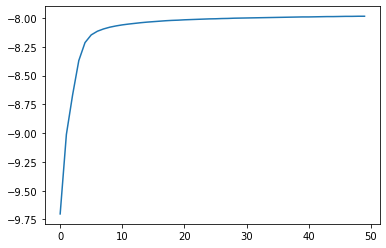

In [27]:
import matplotlib.pyplot as plt
plt.plot(loglikelihoods)

In [28]:
print(loglikelihoods)

[-9.702, -9.012, -8.669, -8.37, -8.214, -8.147, -8.115, -8.095, -8.08, -8.069, -8.06, -8.053, -8.047, -8.041, -8.036, -8.032, -8.028, -8.024, -8.021, -8.019, -8.016, -8.014, -8.012, -8.01, -8.008, -8.007, -8.005, -8.004, -8.002, -8.001, -8.0, -7.999, -7.998, -7.997, -7.996, -7.995, -7.994, -7.993, -7.992, -7.991, -7.991, -7.99, -7.989, -7.988, -7.988, -7.987, -7.986, -7.986, -7.985, -7.985]


In [29]:
loglikelihoods[20]

-8.016

How do you interpret your plot? Based on the plot, what would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds. Do you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;4?

*Upon inspection the plot reflects that log-likelihood starts to converge to max value somewhere near 10 passes (elbow). This means that thee is not a lot of incremental benefit in terms of computational expenses beyond choosing a value beyond, say 20. Considering this graph shows convergence, we can pick a value higher than 50 too for more coherence. Since there is no one correct solution, we can test for different passes and compare. But the elbow plot, gives us a reference point to start from. So, we test for 20, 30, 40 & 80 passes.*

In [30]:
model_20 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=20
    )

model_30 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=30
    )

model_40 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=40
    )

model_80 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    passes=80
    )

In [31]:
model_20.print_topics()

[(0,
  '0.023*"world" + 0.017*"america" + 0.015*"peace" + 0.010*"people" + 0.009*"nations" + 0.008*"freedom" + 0.008*"american" + 0.007*"united" + 0.006*"security" + 0.006*"states"'),
 (1,
  '0.016*"america" + 0.014*"years" + 0.011*"people" + 0.011*"year" + 0.009*"children" + 0.009*"world" + 0.008*"great" + 0.008*"century" + 0.007*"americans" + 0.007*"tonight"'),
 (2,
  '0.015*"congress" + 0.015*"children" + 0.011*"new" + 0.009*"teachers" + 0.009*"help" + 0.008*"federal" + 0.007*"schools" + 0.007*"year" + 0.007*"national" + 0.007*"standards"'),
 (3,
  '0.015*"people" + 0.015*"work" + 0.014*"new" + 0.013*"year" + 0.012*"tax" + 0.012*"years" + 0.012*"children" + 0.010*"families" + 0.009*"help" + 0.009*"care"'),
 (4,
  '0.013*"new" + 0.010*"energy" + 0.010*"congress" + 0.008*"trade" + 0.007*"policy" + 0.007*"economic" + 0.007*"administration" + 0.006*"nation" + 0.005*"development" + 0.005*"program"'),
 (5,
  '0.022*"health" + 0.017*"care" + 0.011*"federal" + 0.011*"women" + 0.011*"medical

*We see some coherent topics:*

- 0: world peace and freedom
- 1: American greatness over the years ?? (mostly incoherent)
- 2: Education standards
- 3: maybe about families, tax regime in the new year (mostly incoherent)
- 4: New trade policies focussed on national development
- 5: Healthcare with some ascpect of specific laws pertaining to women
- 6: Work & welfare rights (mostly incoherent)
- 7: Another (mostly incoherent) mixed topic with some aspect of work related policies
- 8: (mostly incoherent)
- 9: Might be a high level summary topic of the SOTU

In [32]:
model_30.print_topics()

[(0,
  '0.013*"america" + 0.009*"thank" + 0.007*"congress" + 0.007*"states" + 0.006*"united" + 0.006*"east" + 0.006*"international" + 0.005*"world" + 0.005*"africa" + 0.005*"peace"'),
 (1,
  '0.021*"health" + 0.017*"years" + 0.015*"care" + 0.014*"americans" + 0.012*"america" + 0.011*"people" + 0.009*"crime" + 0.008*"insurance" + 0.007*"medicare" + 0.007*"work"'),
 (2,
  '0.028*"federal" + 0.020*"administration" + 0.018*"government" + 0.015*"programs" + 0.013*"policy" + 0.009*"congress" + 0.008*"years" + 0.007*"president" + 0.006*"regulations" + 0.006*"agencies"'),
 (3,
  '0.027*"tax" + 0.027*"budget" + 0.016*"year" + 0.014*"government" + 0.013*"growth" + 0.013*"billion" + 0.012*"federal" + 0.011*"inflation" + 0.011*"economic" + 0.011*"deficit"'),
 (4,
  '0.020*"let" + 0.019*"people" + 0.017*"know" + 0.015*"america" + 0.013*"work" + 0.013*"children" + 0.012*"american" + 0.008*"family" + 0.008*"americans" + 0.008*"country"'),
 (5,
  '0.017*"soviet" + 0.016*"nuclear" + 0.009*"forces" + 0.

*We noted some improved coherence in the topics with 30 passes*

- 0: Foreign Policy with focus on East & Africa
- 1: Healthcare insurance with some overlap with crime
- 2: Federal regulations
- 3: Economic summary of the country
- 4: Importance of American family values and children
- 5: Foreign Military policy with Europe
- 6: mostly incoherent, but maybe national security or energy policy?
- 7: Peace keeping efforts, but some overlap with trade policies
- 8: Law & Order in the country with focus on women??
- 9: Policies for children & schools

In [33]:
model_40.print_topics()

[(0,
  '0.012*"grade" + 0.010*"row" + 0.007*"buying" + 0.006*"dropped" + 0.006*"spend" + 0.005*"assault" + 0.005*"proposal" + 0.004*"sensible" + 0.004*"threats" + 0.004*"government"'),
 (1,
  '0.033*"tax" + 0.018*"new" + 0.009*"credit" + 0.009*"investment" + 0.008*"development" + 0.008*"incentives" + 0.007*"class" + 0.007*"propose" + 0.007*"middle" + 0.007*"businesses"'),
 (2,
  '0.026*"america" + 0.019*"world" + 0.013*"people" + 0.010*"nation" + 0.010*"century" + 0.010*"new" + 0.009*"years" + 0.009*"tonight" + 0.008*"americans" + 0.008*"time"'),
 (3,
  '0.017*"crime" + 0.013*"america" + 0.012*"community" + 0.010*"people" + 0.010*"peace" + 0.008*"new" + 0.007*"congress" + 0.007*"american" + 0.006*"year" + 0.006*"police"'),
 (4,
  '0.018*"federal" + 0.016*"security" + 0.015*"budget" + 0.013*"social" + 0.012*"years" + 0.012*"year" + 0.011*"spending" + 0.010*"programs" + 0.009*"billion" + 0.009*"congress"'),
 (5,
  '0.020*"speaker" + 0.013*"president" + 0.013*"weapons" + 0.012*"fellow" + 

*Not detailing this out, but we noted a similar coherence level of topics with 40 passes as with 30 passes.*

In [57]:
model_80.print_topics()

[(0,
  '0.016*"space" + 0.013*"new" + 0.006*"history" + 0.006*"second" + 0.006*"meet" + 0.006*"world" + 0.005*"teacher" + 0.005*"imports" + 0.005*"rewards" + 0.004*"fuels"'),
 (1,
  '0.012*"gun" + 0.009*"guns" + 0.008*"chemical" + 0.008*"new" + 0.007*"row" + 0.007*"science" + 0.006*"cancer" + 0.006*"organized" + 0.005*"frontiers" + 0.005*"leading"'),
 (2,
  '0.023*"america" + 0.015*"new" + 0.013*"children" + 0.011*"work" + 0.011*"people" + 0.010*"world" + 0.010*"americans" + 0.009*"community" + 0.009*"century" + 0.009*"nation"'),
 (3,
  '0.013*"new" + 0.011*"economic" + 0.009*"energy" + 0.008*"policy" + 0.008*"administration" + 0.007*"federal" + 0.007*"program" + 0.007*"congress" + 0.007*"trade" + 0.007*"growth"'),
 (4,
  '0.015*"congress" + 0.014*"college" + 0.013*"people" + 0.011*"education" + 0.009*"pass" + 0.009*"children" + 0.008*"young" + 0.008*"ask" + 0.007*"new" + 0.007*"bill"'),
 (5,
  '0.022*"health" + 0.022*"care" + 0.020*"work" + 0.017*"children" + 0.016*"welfare" + 0.014*"

*With 80 passes we some topics come out very clearly - gun ownership policy, Economic & Trade policies, Healthcare, Schools & Education, Foreign policy wrt China & Russia, Crime & Women Safety.*

**Overall Summary of findings: As we saw in the elbow shaped plot, convergence is seen after 10 passes, so we keep seeing improvement in topic coherence as we choose higher number of passes. But since the exercise is subjective interpretation, out choice should be motivated by keeping in mind computational complexity and also diminishing coherence benefit with increasing passes. We think, the optimal choice would be to use 40 passes.**

## Reflection questions

The following reflection questions will help you prepare for the diagnostic test. Answer each of them in the form of a short text and put your answers in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 3.1:** Based on your experiments in Problem&nbsp;2 and Problem&nbsp;3, what is the relation between the quality of a clustering and the number of clusters? What happens when the number of clusters is too low, or too high? For this particular data set, what would a &lsquo;good&rsquo; number of clusters be?

*From the RI values we computed for k = 1,3,5 and 7, we saw the quality of clustering went up each time. But since, with this limited test we did not check if, at current or higher k values, the RI plateau or peak, so, based on what we found with the given experiment design, we can expect better clustering performance with higher values of k. To tune the 'k' hyperparameter, we would need to plot the inertia for each subsequent clustering and find the 'elbow' in the  inertia plot. Considering, that the full data contains 6 categories (which served as gold standard labels for evaluation), intuitively, 6 clusters is what we would expect. But we have to keep in mind the limitations of the KMeans clustering i.e. KMeans finds clusters with convex shapes and it doesn't handle outliers well. Its merely conjecture on our part, but reviews on books and dvds can utilize a lot of common words and thus be act as outliers for each others clusters and pull the centroids of each cluster towards them. This can be a reason why the qualit of clusters for this dataset maybe limited using KMeans.*

**RQ 3.2:** Explain why it is important to monitor an LDA model for convergence and not simply use, say, 1000&nbsp;passes. How is the log likelihood used in this context? Were the topics from the multi-pass model &lsquo;better&rsquo; than the topics from the 1-pass model?

*We reasoned this earlier in the report as well, but to recap, since we see convergence after a certain number of passes, the plot suggests we can keep improving our topic quality results with higher passes, but this obviously comes at a higher training cost and we also saw diminishing returns on quality of topics with increasing number of passes. The log-likelihood is the marginal probability $p(word|topic)$ drawn from the unigram model. With each pass, as with weights propagating through hidden layers in a neural network, we expect convergence. Hence, here we use the log-likelihood values to determine where convergence takes place and expect the number of topics in our data. The topics discovered during the experiments were explained earlier.*

**RQ 3.3:** What are the differences between $k$-means and LDA? When would you use one, when the other?

*The difference between k-means and LDA is their clustering type. k-means is a hard clustering technique while LDA is a soft clustering approach. The clearest way to understand how they differ from each other is how they group documents. k-means will assign each document to a particular cluster while LDA would assign a document to multiple topics or a mixture of topics. k-means is more suitable as an exploratory tool to understand the data better and how its distributed. To get a sense of context and structure within the text data we should use LDA which lets us find more realistic and contextual results in topic identification. In other words, use k-means when the objective is to find high level grouping and pre-processing; use LDA when the objective is gain knowledge of context in text data.*

In [61]:
pd.value_counts(eval_data['category'])

camera      99
music       83
software    82
dvd         80
books       78
health      78
Name: category, dtype: int64

*TODO: Enter your answers here*

**Congratulations on finishing L3! 👍**